<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/RNN_For_1D_Colored_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librarys

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, LSTM, GRU, RNN,SimpleRNN
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from datetime import datetime # for put the time info in each plot          #https://stackoverflow.com/questions/415511/how-to-get-the-current-time-in-python

## Downloading data

In [ ]:
#Monting Google Drive
# https://medium.com/analyatics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
!kaggle datasets download -d luanorionbarana/synthetic-colored-noise
#Unziping data-set
!unzip "synthetic-colored-noise.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle
synthetic-colored-noise.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  synthetic-colored-noise.zip
replace /content/color.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
ls

kaggle.json  synthetic-colored-noise.zip


In [ ]:
#Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content


In [ ]:
df = pd.read_pickle('color_4series.plk')

## Ploting

In [ ]:
index = [0,4,9]

Text(0, 0.5, 'Amplitude')

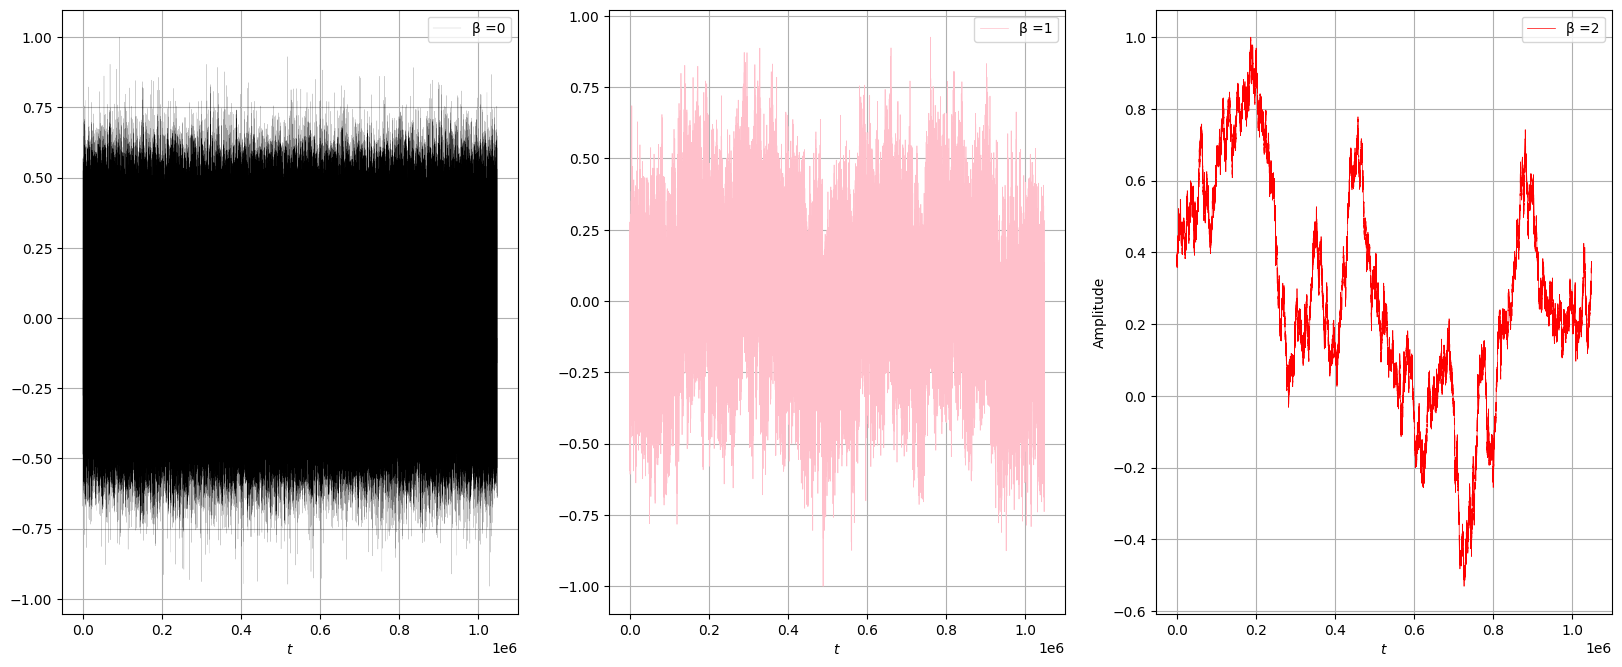

In [ ]:

color = ['black','pink','red']
linewidth = [0.07,0.5,.5]
plt.figure(figsize=(20,8),dpi=100)
for i in range(len(index)):
  plt.subplot(1,3,i+1)
  plt.plot(df.Series[index[i]][:],label='β ='+str(df.beta[index[i]]),color=color[i],linewidth=linewidth[i])
  plt.grid()
  plt.legend()
  plt.xlabel('$t$')
plt.ylabel('Amplitude')
  #plt.title(color[i]+ ' noise')
#plt.suptitle('Colored Noise')


# Pre-processing

In [ ]:
#serie_index = 0  #white Noise
#serie_index = 40 #pink noise
serie_index =  9#red Noise

min_size , max_size = 0 , len(df.Series[0])

dataframe = pd.DataFrame({"Serie":df['Series'][serie_index][min_size:max_size]})
dataset = dataframe.values.astype('float32')
beta = str(df['beta'][serie_index])

In [ ]:
# definindo as amostras de treinamento e teste segundo o hold-out.
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#val_size = 5000
#train, test, val = dataset[0:train_size,:], dataset[train_size:len(dataset),:], dataset[len(dataset):len(dataset)+val_size,:]

In [ ]:
# conversão da série temporal em uma matriz de atributos para regressão
def create_dataset(dataset, look_back=10):
	'''
  Essa função irá criar dois vetores, dataX e dataY, o dataX irá conter um conjuntos de números dentro da série temporal
  e o dataY será o seu valor a posteriorí

  Por ex: 
  lista = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  se o look_back for igual a 3 teremos 
  dataX[0] = [0,1,2] ; dataY[0] = [3]
  dataX[1] = [1,2,3] ; dataY[1] = [4]
  dataX[2] = [2,3,4] ; dataY[2] = [5]
  dataX[3] = [3,4,5] ; dataY[3] = [6]
  ...
	'''
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1000
trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test,  look_back)
#valX, valY     = create_dataset(val,   look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX,(trainX.shape[0],1, trainX.shape[1]))
testX =  np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#valX =   np.reshape(valX,  (valX.shape[0],  1, valX.shape[1]))

# Model

In [ ]:
#Setting Random seeds🌱
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(3)

In [ ]:
star = time.time()
#Paramenters 
epochs = 100
batch_size = look_back*10
#batch_size = len(trainX)#

model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, return_sequences=True,input_shape=(1,look_back)))
model_RNN.add(SimpleRNN(100, return_sequences=True))
model_RNN.add(SimpleRNN(100))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_RNN = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.7)
time_RNN = time.time()

model_LSTM = Sequential()
model_LSTM.add(LSTM(100, return_sequences=True, input_shape=(1, look_back)))
model_LSTM.add(LSTM(100, return_sequences=True))
model_LSTM.add(LSTM(100))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_LSTM = model_LSTM.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.7)
time_LSTN = time.time()

model_GRU = Sequential()
model_GRU.add(GRU(100,   return_sequences=True, input_shape=(1, look_back)))
model_GRU.add(GRU(100, return_sequences=True))
model_GRU.add(GRU(100))
model_GRU.add(Dense(1))
model_GRU.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_GRU = model_GRU.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.7)
time_GRU = time.time()


In [ ]:
Time =[round((time_RNN - star)/60,5), round((time_LSTM - time_RNN)/60,5), round((time_GRU - time_LSTM)/60,5)]
for i in range (len(model)):  print(model_name[i],Time[i],'minutus') if Time[i] < 100 else print(model_name[i],round(Time[i]/60,4),'hours')

In [ ]:
# epochs = 100
# model_RNN = Sequential()
# model_RNN.add(SimpleRNN(4, input_shape=(1, look_back)))
# model_RNN.add(Dense(1))
# model_RNN.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
# history_RNN = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=len(trainX), verbose=0,validation_split=0.7)

# model_LSTM = Sequential()
# model_LSTM.add(LSTM(4, input_shape=(1, look_back)))
# model_LSTM.add(Dense(1))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
# history_LSTM = model_LSTM.fit(trainX, trainY, epochs=epochs, batch_size=len(trainX), verbose=0,validation_split=0.7)

# model_GRU = Sequential()
# model_GRU.add(GRU(4, input_shape=(1, look_back)))
# model_GRU.add(Dense(1))
# model_GRU.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
# history_GRU = model_GRU.fit(trainX, trainY, epochs=epochs, batch_size=len(trainX), verbose=0,validation_split=0.7)


In [ ]:
star = time.time()
#Paramenters 
epochs = 100
batch_size = look_back*10
#batch_size = len(trainX)#

model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, return_sequences=True,input_shape=(1,look_back)))
model_RNN.add(SimpleRNN(100, return_sequences=True))
model_RNN.add(SimpleRNN(100))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_RNN = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.7)
time_RNN = time.time()

model_LSTM = Sequential()
model_LSTM.add(LSTM(100, return_sequences=True, input_shape=(1, look_back)))
model_LSTM.add(LSTM(100, return_sequences=True))
model_LSTM.add(LSTM(100))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_LSTM = model_LSTM.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.7)
time_LSTN = time.time()

model_GRU = Sequential()
model_GRU.add(GRU(100,   return_sequences=True, input_shape=(1, look_back)))
model_GRU.add(GRU(100, return_sequences=True))
model_GRU.add(GRU(100))
model_GRU.add(Dense(1))
model_GRU.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_GRU = model_GRU.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0,validation_split=0.7)
time_GRU = time.time()


In [ ]:
#Alocationg all the models in vectors!
model = [model_RNN,model_LSTM,model_GRU]
history = [history_RNN,history_LSTM,history_GRU]
model_name = ['RNN','LSTM','GRU']
color = ['C0','C1','C2']

#Allocating metrics
loss, mse, val_loss =[],[],[]
for i in range(len(model)):
  loss.append(history[i].history['loss'])
  mse.append(history[i].history['mse'])
  val_loss.append(history[i].history['val_loss'])

# Model Results

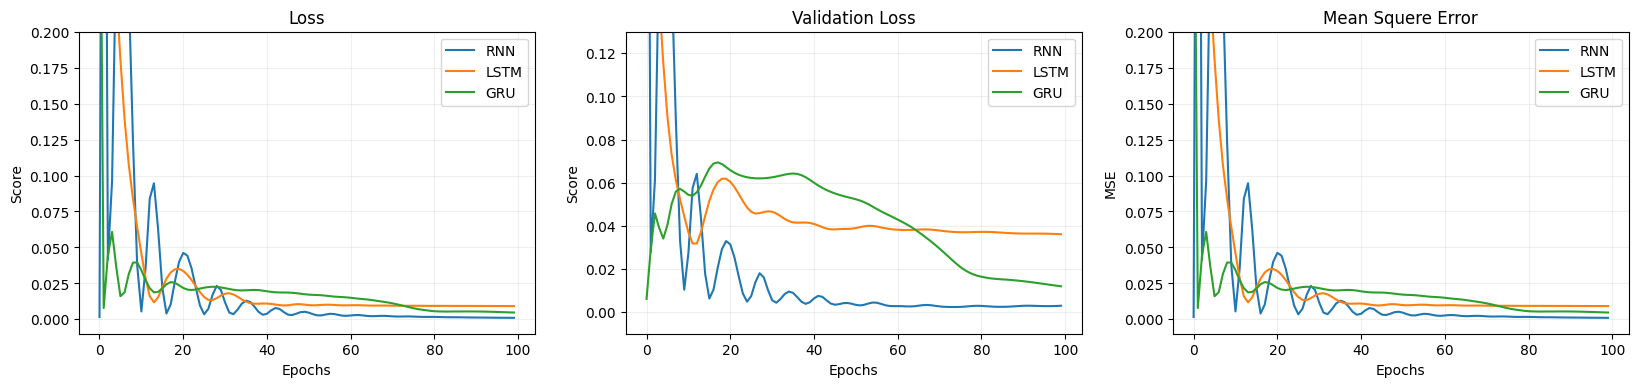

In [ ]:
epochs = np.arange(0,len(loss[0]))
plt.figure(figsize=(20, 4),dpi=100)

plt.subplot(1,3,1)
for i in range(len(model)): plt.plot(epochs,loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Loss')
plt.ylim(-0.01,0.2)
plt.grid(alpha=0.2)

plt.subplot(1,3,2)
for i in range(len(model)): plt.plot(epochs,val_loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Loss')
plt.ylim(-0.01,0.13)
plt.grid(alpha=0.2)


plt.subplot(1,3,3)
for i in range(len(model)): plt.plot(epochs,mse[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title("Mean Squere Error")
plt.ylim(-0.01,0.2)
plt.grid(alpha=0.2)

plt.show()

In [ ]:
'''
Aqui iremos alocar a previsão do treinamento, to teste e de ambos em vetores. 
Para o caso dos valores de test eles precisam estar na posição em que o treinamento acaba para que possamos comparar no mesmo dataset
'''

# make predictions
trainPredict, testPredict, trainPredictPlot, testPredictPlot, model_data = [],[],[],[],[]

for i in range(len(model)):
  #Train
  trainPredict.append(model[i].predict(trainX))
  a = np.empty_like(dataset)
  a[:, :] = np.nan
  a[look_back:len(trainPredict[i])+look_back, :] = trainPredict[i]
  trainPredictPlot.append(a)
  #Teste
  testPredict.append(model[i].predict(testX))
  a = np.empty_like(dataset)
  a[:, :] = np.nan
  a[len(trainPredict[i])+(look_back*2)+1:len(dataset)-1, :] = testPredict[i]
  testPredictPlot.append(a)
  #All
  a =  np.empty_like(dataset) #creating a empyt vector
  a[look_back:len(trainPredict[i])+look_back, :] = trainPredict[i] #alocating the the traint data generatead by the model
  a[len(trainPredict[i])+(look_back*2)+1:len(dataset)-1, :] = testPredict[i] #alocating the the test data generatead by the model
  a = (np.reshape(a,(len(a))))
  a[:look_back] = np.nan
  #model_data = model_data[look_back:]
  # Killing divergences
  for i in range(len(a)):
      if a[i] > 1: a[i] = np.nan
      #if a[i] < 0.0001: a[i] = 0
  model_data.append(a)   
del a  


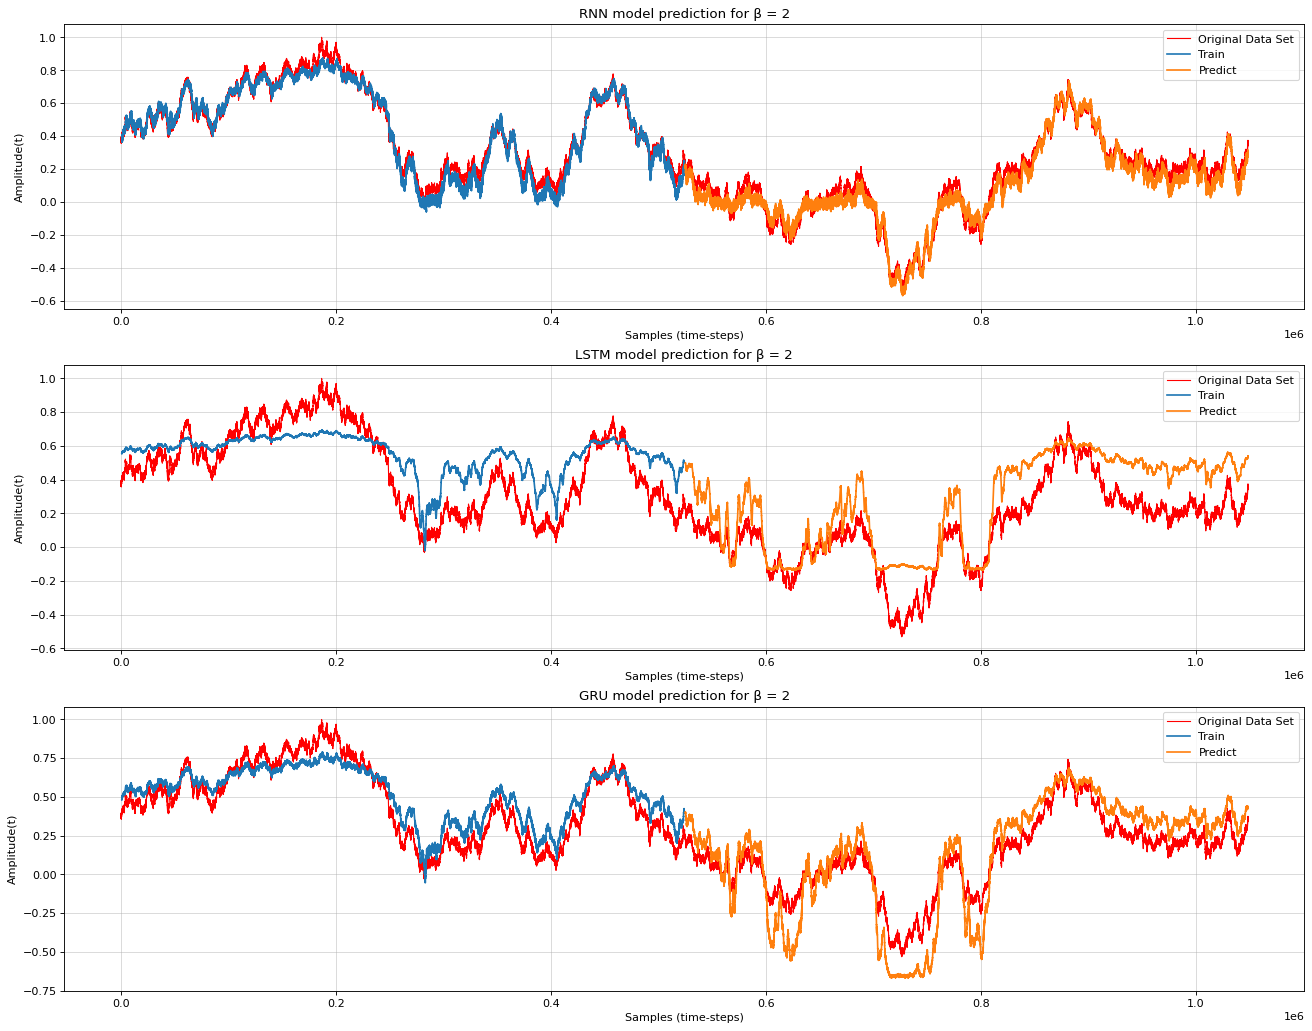

In [ ]:
i=2
if   beta == '0.0': df_color = 'black'
elif beta == '1.0': df_color = 'magenta'
else                     : df_color = 'red'

grossura = 0.5 if beta== '0.0' else 1

plt.figure(figsize = (20,4*len(model)+4), dpi=80)
for i in range(len(model)):
  plt.subplot(len(model),1,(i+1))
  plt.plot(dataset,label="Original Data Set",color = df_color,linewidth=grossura)
  plt.plot(trainPredictPlot[i],label='Train',color='C0')
  plt.plot(testPredictPlot[i],label='Predict',color='C1')
  plt.title(str(model_name[i])+' model prediction for β = '+str(beta))
  plt.ylabel('Amplitude(t)')
  plt.xlabel('Samples (time-steps)')
  plt.legend()
  plt.grid(alpha=0.5)
plt.show()

# SpecPlus

Geração do Espctro de Potência de uma série temporal

In [ ]:

def specplus(nomeArquivo,INICIO=10,FIM=6300, textoTituloPSD = r'Original Time Series - ',corPSD2 =  'navy'):
    #FIM = 2**int(np.log2(len(trainPredict[i]))-1)
    import matplotlib.pyplot as plt
    import matplotlib.mlab as mlab
    from scipy import stats, optimize
    import numpy as np
    import math
 
    #---------------------------------------------------------------------
    # Calcula o PSD da série temporal
    #---------------------------------------------------------------------

    def psd(data):
        """Calcula o PSD de uma série temporal."""
        # Define um intervalo para realizar o ajuste da reta
        # INICIO = 15
        # FIM = 6300
        # O vetor com o tempo é o tamanho do número de pontos
        N = len(data)#int(len(data)/2)
        tempo = np.arange(len(data))
        # Define a frequência de amostragem
        dt = (tempo[-1] - tempo[0] / (N - 1))
        fs = 1 / dt
        # Calcula o PSD utilizando o MLAB
        power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)
        # Calcula a porcentagem de pontos utilizados na reta de ajuste
        totalFrequencias = len(freqs)
        totalPSD = FIM - INICIO
        porcentagemPSD = int(100 * totalPSD / totalFrequencias)
        # Seleciona os dados dentro do intervalo de seleção
        xdata = freqs[INICIO:FIM]
        ydata = power[INICIO:FIM]
        # Simula o erro
        yerr = 0.2 * ydata
        # Define uma função para calcular a Lei de Potência
        powerlaw = lambda x, amp, index: amp * (x**index)
        # Converte os dados para o formato LOG
        logx = np.log10(xdata)
        logy = np.log10(ydata)
        # Define a função para realizar o ajuste
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err    
        logyerr = yerr / ydata
        # Calcula a reta de ajuste
        pinit = [1.0, -1.0]
        out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)    
        pfinal = out[0]
        covar = out[1]
        index = pfinal[1]
        amp = 10.0 ** pfinal[0]
        indexErr = np.sqrt(covar[0][0])
        ampErr = np.sqrt(covar[1][1]) * amp
        # Retorna os valores obtidos
        return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM


    def main():
        """Função com o código principal do programa."""
        #print("\nSpectral Analysis for time series...\n")
        # Desabilita as mensagens de erro do Numpy (warnings)
        old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
        # Carrega o arquivo de dados
        #nomeArquivo = 'serie1.txt'		

        pd.DataFrame(nomeArquivo[:2**int(np.log2(len(nomeArquivo)))]).to_csv("data.csv", index=False, header=False)
        #pd.DataFrame(model_data[0][:2**int(np.log2(len(model_data)))]).to_csv("model.csv", index=False, header=False)

        #csv_para_txt
        import csv
        with open("data.txt", "w") as my_output_file: 
            with open("data.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
            my_output_file.close()

        data = np.genfromtxt('data.txt',
                             delimiter = ',',
                             dtype = 'float32',
                             filling_values = 0)

        # Exibe os primeiro N valores do arquivo
        #N = 10
        #fig = plt.figure(figsize=(6,4), dpi=100)
        #fig.subplots_adjust(hspace = .4, wspace = .2)
        # Tamanho das fontes
        tamanhoFonteEixoX     = 16
        tamanhoFonteEixoY     = 20
        tamanhoFonteTitulo    = 16
        tamanhoFontePrincipal = 25
        # Título principal
        tituloPrincipal = 'Time Series Spectral Analysis' 	
        #-----------------------------------------------------------------
        # Plotagem da série original
        #-----------------------------------------------------------------
        # Define as cores da plotagem
        #corSerieOriginal = cor# 'r'
        # Título dos eixos da série original
        textoEixoX = 'Time'
        textoEixoY = 'Amplitude'
        #textoTituloOriginal = titulo

        #-----------------------------------------------------------------
        # Cálculo e plotagem do PSD                                     --
        #-----------------------------------------------------------------
        # Calcula o PSD
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)
        # O valor do beta equivale ao index
        b = index
        # Define as cores da plotagem
        corPSD1 = 'k'
        #corPSD2 =  'orange' if modelo_nome == 'GRU' else 'green'
        #corPSD2 =  'navy'# if nomeArquivo == 'serie_time.txt' else 'orange' if modelo_nome == 'GRU' else 'green'
        # Título dos eixos do PSD
        textoPSDX = 'Frequency (Hz)'
        textoPSDY = 'PSD'
        #textoTituloPSD = r''+str(modelo_nome)+' - PSD Estimation β = '
        # Plotagem do PSD    
        #PSD = fig.add_subplot(2, 2, (1,4))    
        plt.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
        plt.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
        plt.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
        plt.axvline(freqs[FIM], color = corPSD2, linestyle = '--')    
        plt.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))    
        plt.xlabel(textoPSDX                                  )#, fontsize = tamanhoFonteEixoX)
        plt.ylabel(textoPSDY                                  )#, fontsize = tamanhoFonteEixoY)
        plt.title(textoTituloPSD + ' β = %.4f' %(b), loc = 'center')#, fontsize = tamanhoFonteTitulo)
        plt.yscale('log')
        plt.xscale('log')
        plt.grid() 
        #fig.set_size_inches(7, 4)
        #plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)	
        #plt.show()

    if __name__ == "__main__":
        main()
    #——————————————————————————————————————————

In [ ]:
len(model)

3

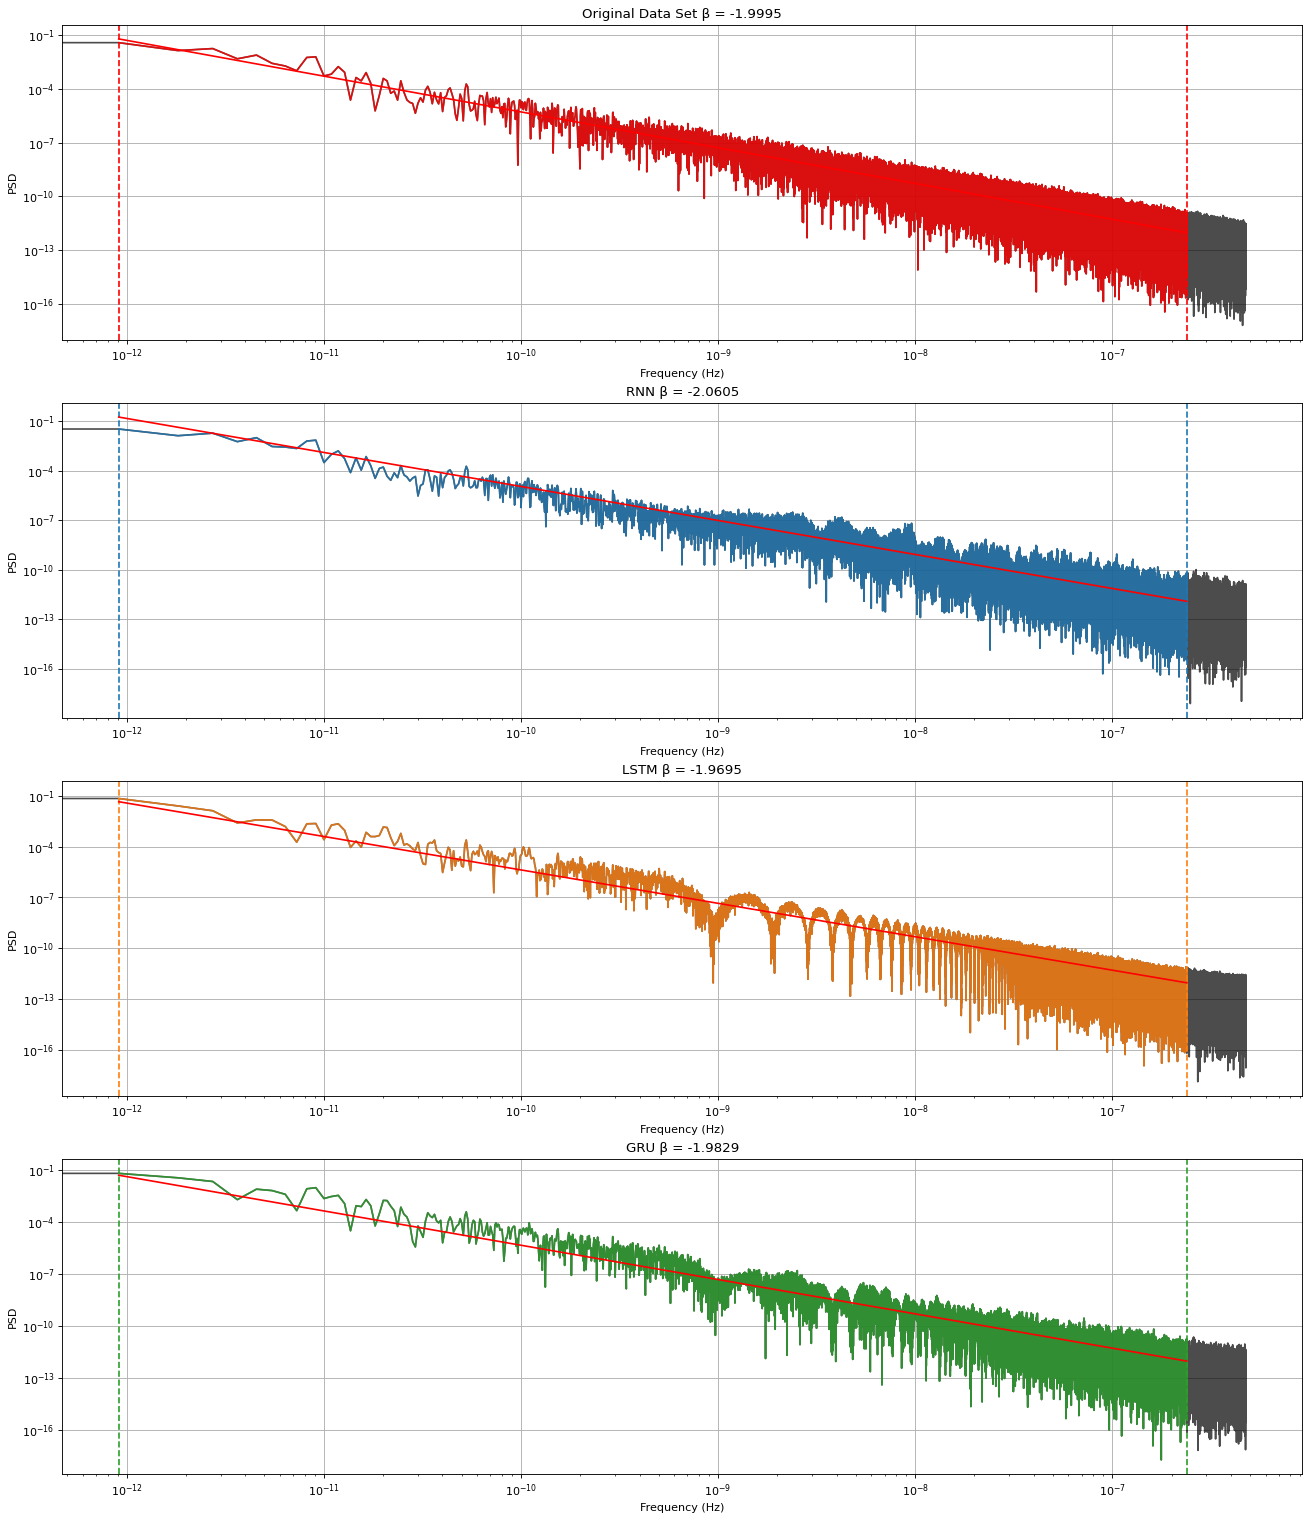

In [ ]:
plt.figure(figsize = (20,4*(len(model)+1)+8), dpi=80)
plt.subplot(len(model)+1,1,1)
specplus(dataset,  #Dataframe
          1,              #Incial Value
          2**int(np.log2(len(dataset))-2), #Final Value
          'Original Data Set',   #Chat Tile
          'red')        #Color
for i in range(len(model)):
  plt.subplot(len(model)+1,1,i+2)
  specplus(model_data[i],  #Dataframe
           1,              #Incial Value
           2**int(np.log2(len(model_data[i]))-2), #Final Value
           model_name[i],   #Chat Tile
           color[i])        #Color
plt.show()

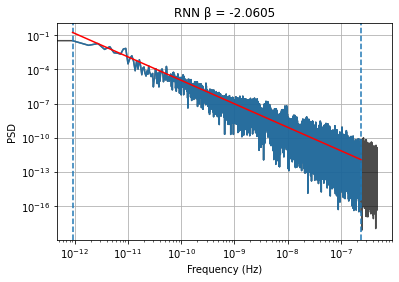

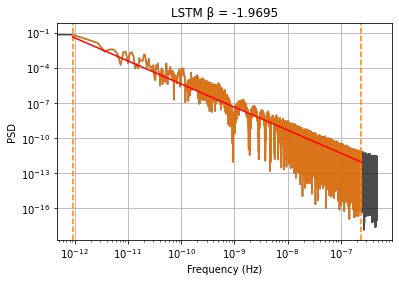

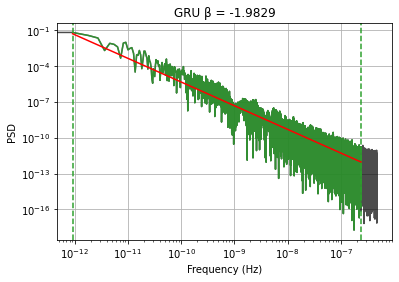

In [ ]:
for i in range(len(index)):
  specplus(model_data[i],  #Dataframe
           1,              #Incial Value
           2**int(np.log2(len(model_data[i]))-2), #Final Value
           model_name[i],   #Chat Tile
           color[i])        #Color


In [ ]:
#remove all
#!rm *

rm: cannot remove 'sample_data': Is a directory


In [ ]:
#Ziping Data for download📦
#!zip -r /content/All_Files.zip /content

# Implement LSTM RNN Models For Univariate Time Series Forecasting

https://www.youtube.com/watch?v=UbvkhuqVqUI&t=154s

https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb